In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from IPython.display import Image

sns.set_theme( style = 'whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

- [1. Wstęp](#1)
- [2. Parametry początkowe](#2)
- [3. Wyniki](#3)
    - [3.1 test programu - stabilność](#31)
    - [3.2 kryształ](#32)
    - [3.3 topienie kryształu](#33)
    - [3.4 gaz](#34)
- [4. Kod symulacji](#4)

<a name='1'></a>
# 1. Wstęp

W ramach ćwiczenia zaimplementowano algorytm dynamiki molekularnej dla układu atomów argonu oddziałujących siłami Van der Waalsa. Obserwowane było przejście fazowe kryształ - gaz. Zbadano także własności termodynamiczne charakteryzujące stan gazowy (temperatura, ciśnienie).

Program do symulacji został napisany w Pythonie (z wykorzystaniem kompilatora numba). 

<a name='2'></a>
# 2. Parametry początkowe

Na początku atomy są rozmieszczone na siatce romboidalnej o maksymalnym upakowaniu.
Pędy są losowane z rokzkładu Maxwella o zadanej temperaturze T0.



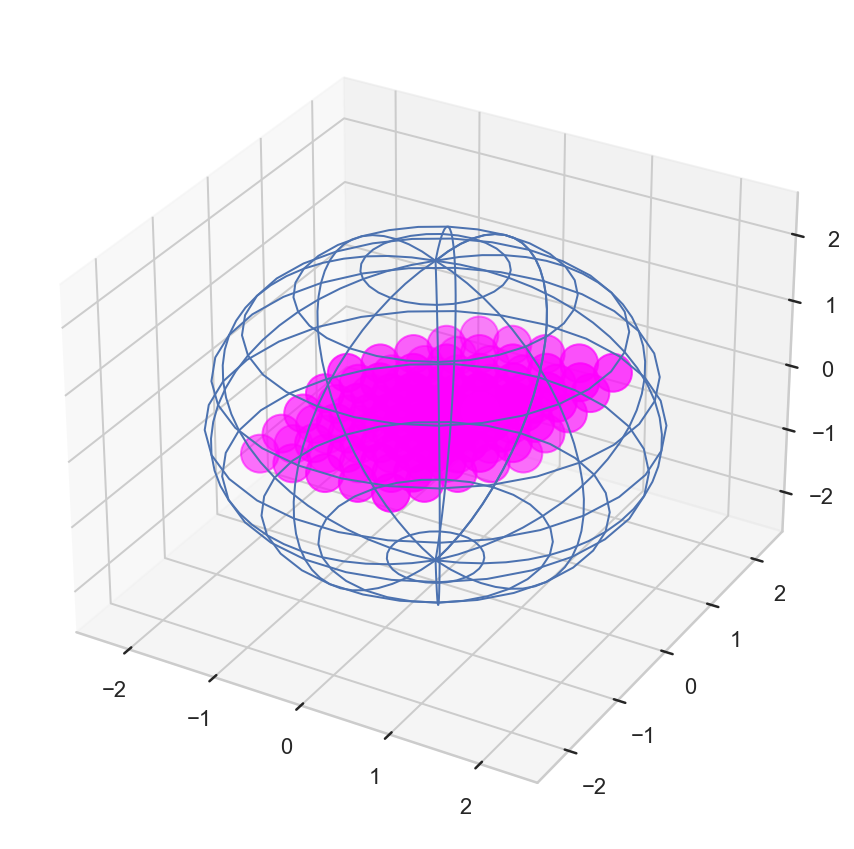

In [19]:
atoms = np.loadtxt("./output/out_pos.txt")

L = 2.3

u = np.linspace(0, np.pi, 30)
v = np.linspace(0, 2 * np.pi, 30)

x = L*np.outer(np.sin(u), np.sin(v))
y = L*np.outer(np.sin(u), np.cos(v))
z = L*np.outer(np.cos(u), np.ones_like(v))

fig = plt.figure(figsize = (12, 6))
ax = plt.axes(projection='3d')

ax.plot_wireframe(x, y, z, rstride=3, cstride=3, linewidth=1)
ax.scatter(atoms[:, 0], atoms[:, 1], atoms[:, 2], c = 'magenta', s = 360)
fig.tight_layout()
plt.savefig('./figs/argon.pdf')

<center>Fig. 1. Początkowe rozmieszczenie atomów dla n = 5, a = 0.38, L = 2.3, T0 = 1000K.</center>

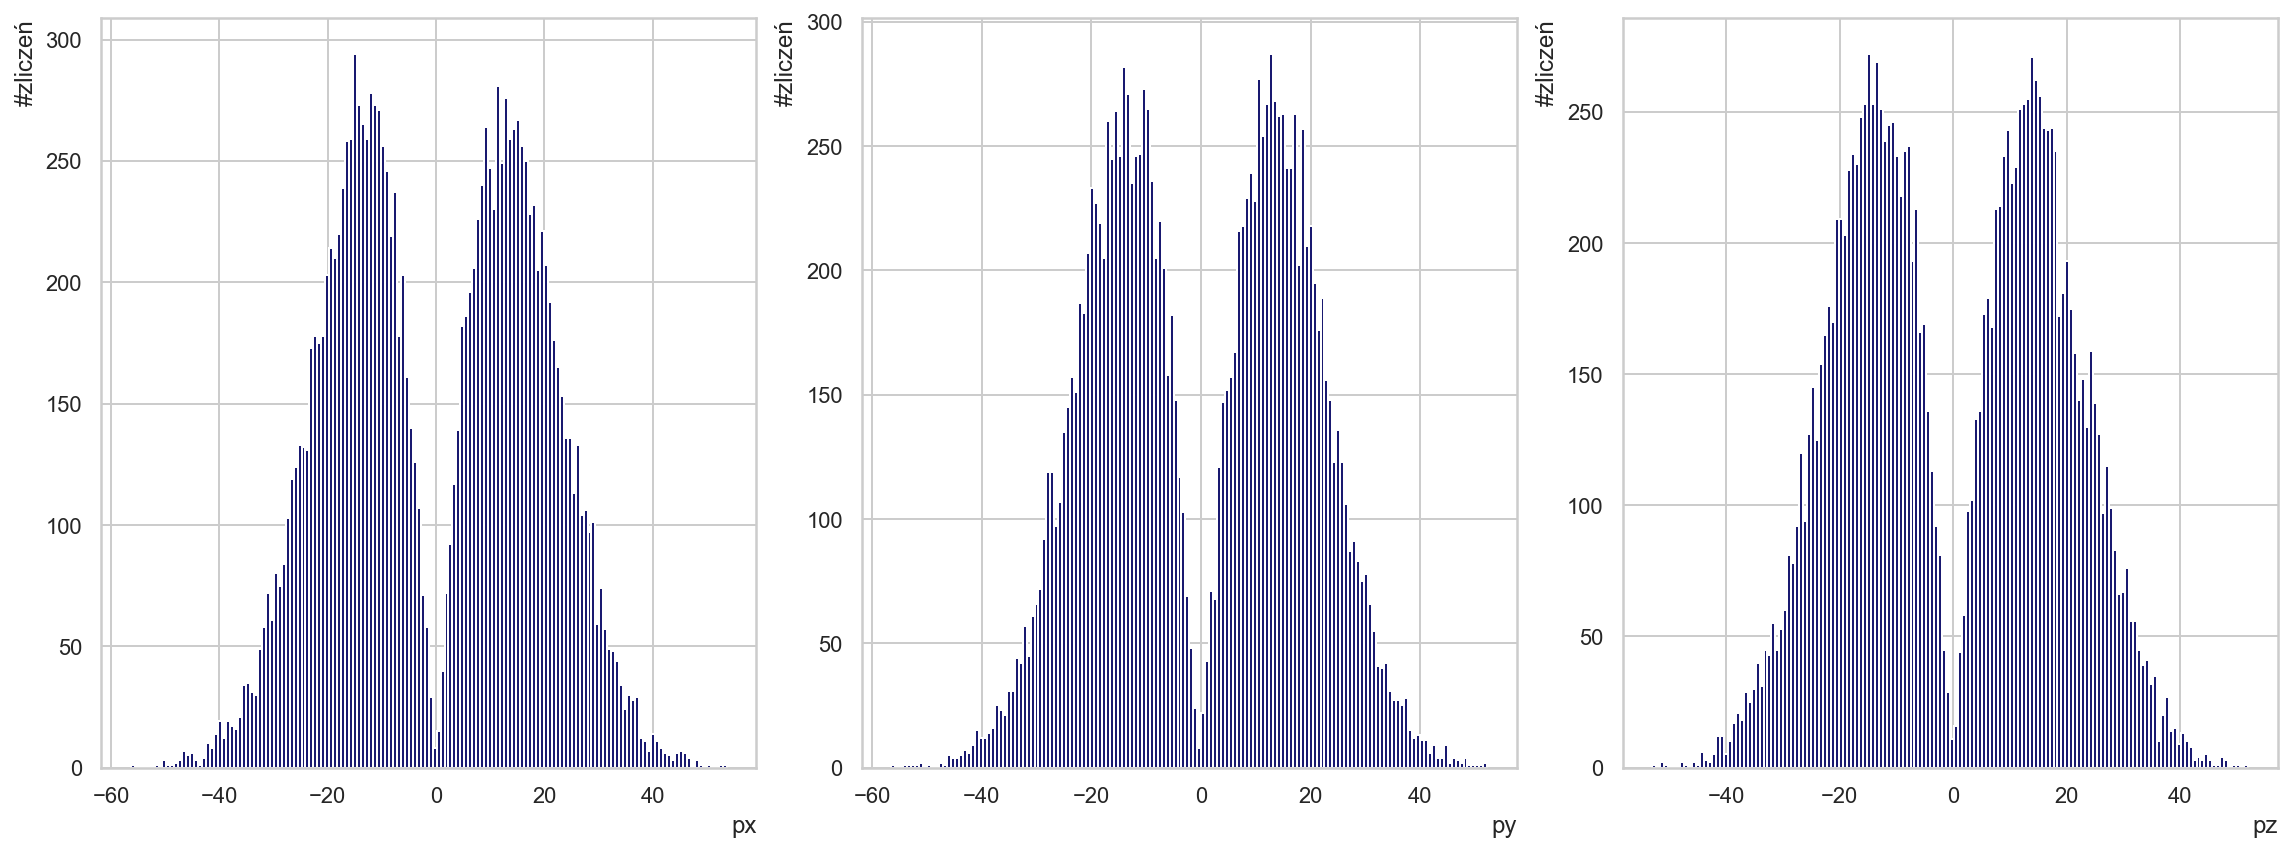

In [20]:
momenta = np.loadtxt("./output/out_mom.txt")
xlabels = ['px', 'py', 'pz']

fig = plt.figure(figsize=(16,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.xlabel(xlabels[i], fontsize=12, loc='right')
    plt.ylabel("#zliczeń", fontsize=12, loc='top')
    plt.hist(momenta[:, i], bins=150, color = "midnightblue")
    ax.tick_params(axis='both', which='major', labelsize=14)
    fig.tight_layout()
plt.savefig('./figs/momenta.pdf')

<center>Fig. 2. Rozkłady pędów początkowych dla n = 25, a = 0.38, L = 2.3, T0 = 1000K.</center>

<a name='3'></a>
# 3. Wyniki

<a name='31'></a>
## 3.1 test programu - stabilność

Zbadano stabilność algorytmu obserwując chwilowy hamiltonian dla różnych kroków czasowych dt.

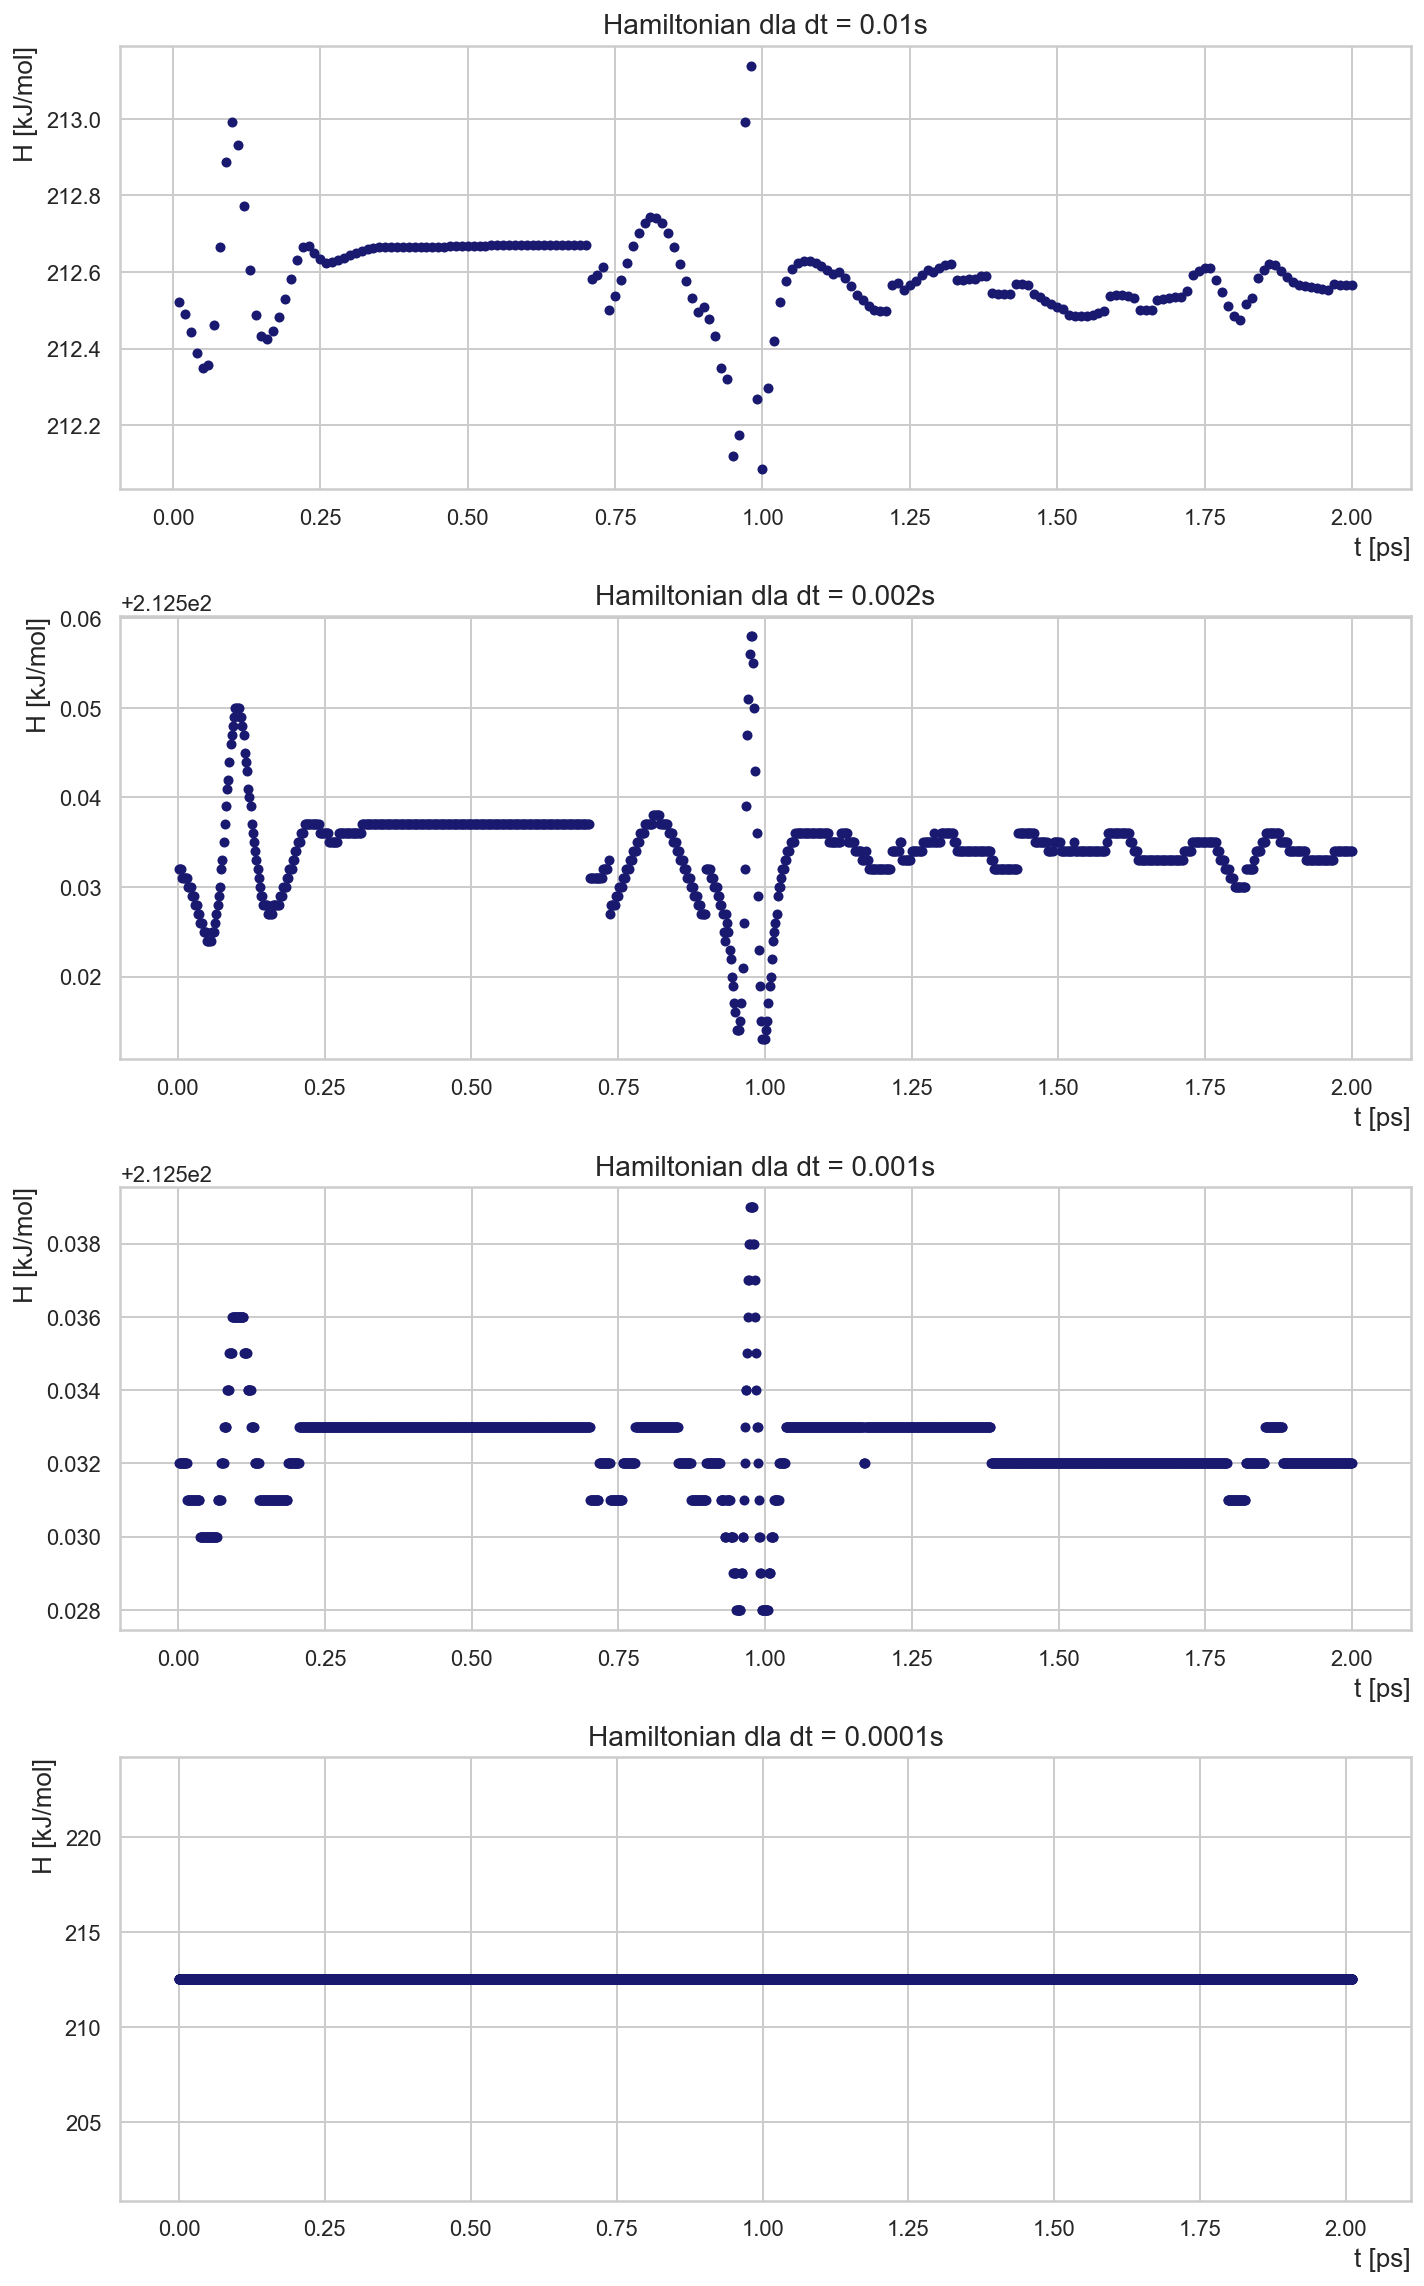

In [34]:
data01 = np.loadtxt("./output/out_t1e-2.txt", skiprows=1)
df01 = pd.DataFrame(data01, columns = ['t','H','V', 'T', 'P'])

data002 = np.loadtxt("./output/out_t2e-3.txt", skiprows=1)
df002 = pd.DataFrame(data002, columns = ['t','H','V', 'T', 'P'])

data001 = np.loadtxt("./output/out_t1e-3.txt", skiprows=1)
df001 = pd.DataFrame(data001, columns = ['t','H','V', 'T', 'P'])

data0001 = np.loadtxt("./output/out_t1e-4.txt", skiprows=1)
df0001 = pd.DataFrame(data0001, columns = ['t','H','V', 'T', 'P'])

datasets = {0 : df01, 1 : df002, 2 : df001, 3 : df0001}
titles = ["01", "002", "001", "0001"]

fig = plt.figure(figsize=(10,16))
for i in range(4):
    plt.subplot(4,1,i+1)
    #plt.axis([0., 2., 212, 213.25])
    plt.xlabel("t [ps]", fontsize=13, loc='right')
    plt.ylabel("H [kJ/mol]", fontsize=13, loc='top')
    plt.title("Hamiltonian dla dt = 0." + titles[i] + "s", fontsize = 14)
    plt.plot(datasets[i]['t'], datasets[i]['H'], 'o', color = "midnightblue", markersize = 4)
    ax.tick_params(axis='both', which='major', labelsize=14)
    fig.tight_layout()
plt.savefig('./figs/stab.pdf')

<center>Fig. 3. Chwilowy hamiltonian dla różnych kroków czasowych dt przy n= 3, a = 0.38 nm , T0 = 1000K, L = 1.2 nm.</center>

Dla dt = 0.001ps zakres fluktuacji hamiltonianu wynosi 0.01, więc można uznać, że algorytm jest wtedy stabilny. Krok ten został wykorzystany do dalszych symulacji.

<a name='32'></a>
## 3.2 kryształ

Dla parametrów n= 5, a ≈0.38nm, L = 2.3 nm, T0 = 0K znaleziono przybliżenie wartości a, dla której energia potencjalna jest minimalna. 

Minimum potencjału  V = -676.483 kJ/mol uzyskano dla a = 0.373 nm

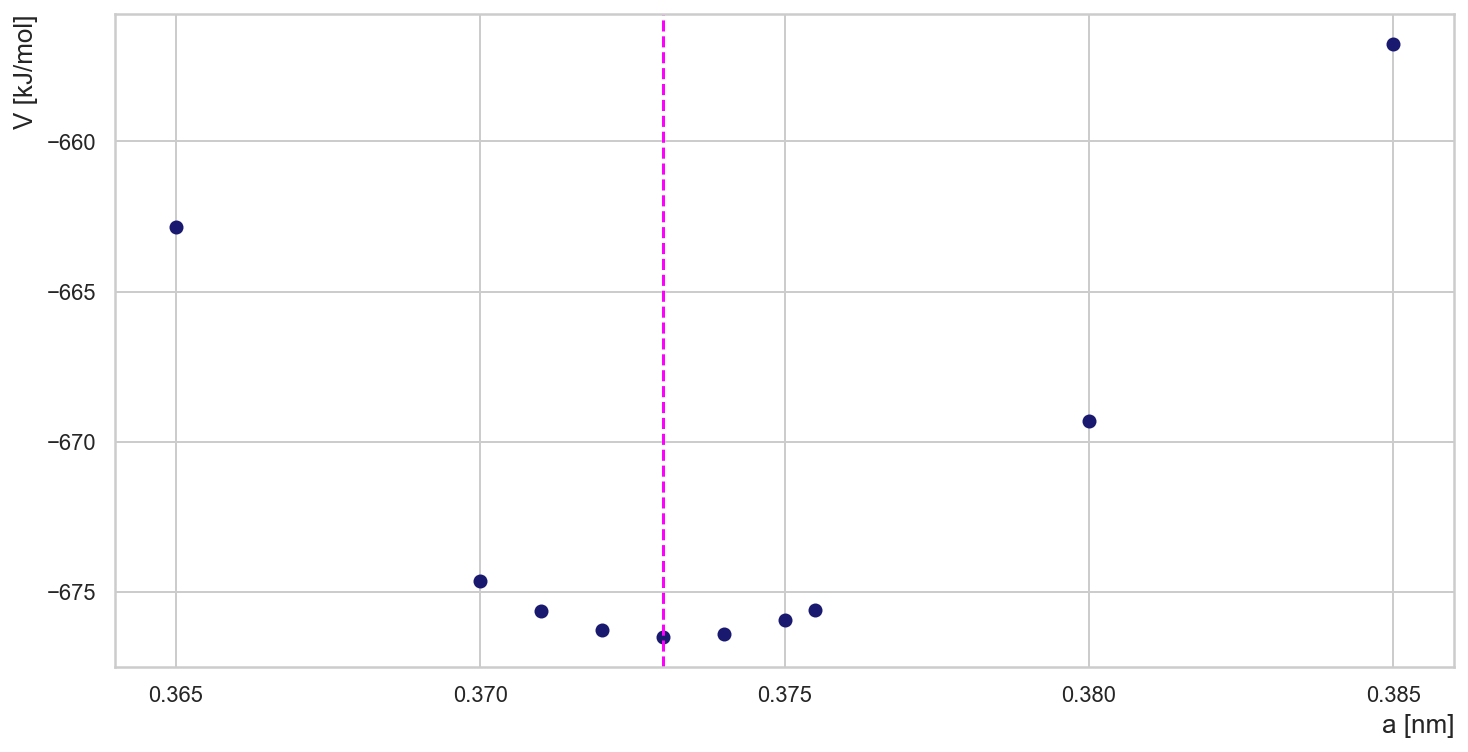

In [22]:
a_data = np.loadtxt("./output/a.txt", skiprows=1)
a_df = pd.DataFrame(a_data, columns = ['a [nm]','V [kJ/mol]'])
fig = plt.figure(figsize = (12, 6))
ax = plt.axes()
plt.scatter(a_df['a [nm]'], a_df['V [kJ/mol]'], color = 'midnightblue')
ax.set_xticks(np.arange(0.365, 0.385, 0.005))
ax.set_yticks(np.arange(-675., -655., 5))
plt.axvline(x=0.373, color = 'magenta', ls = '--')
plt.xlabel("a [nm]", fontsize=13, loc='right')
_ = plt.ylabel("V [kJ/mol]", fontsize=13, loc='top')
plt.savefig('./figs/a.pdf')

<center>Fig. 4. Zalezność początkowej wartości energii potencjalnej od parametru a.</center>

W wyniku symulacji dla tak zadanego a po 1ps otrzymano temperaturę średnią Tavr = 0.146K 
Niezerowa wartość temperatury wynika z oddziaływań Van der Waalsa między atomami. Po wyłączeniu tych oddziaływań temperatura chwilowa była cały czas równa 0.

Krzyształ był stabilny. 


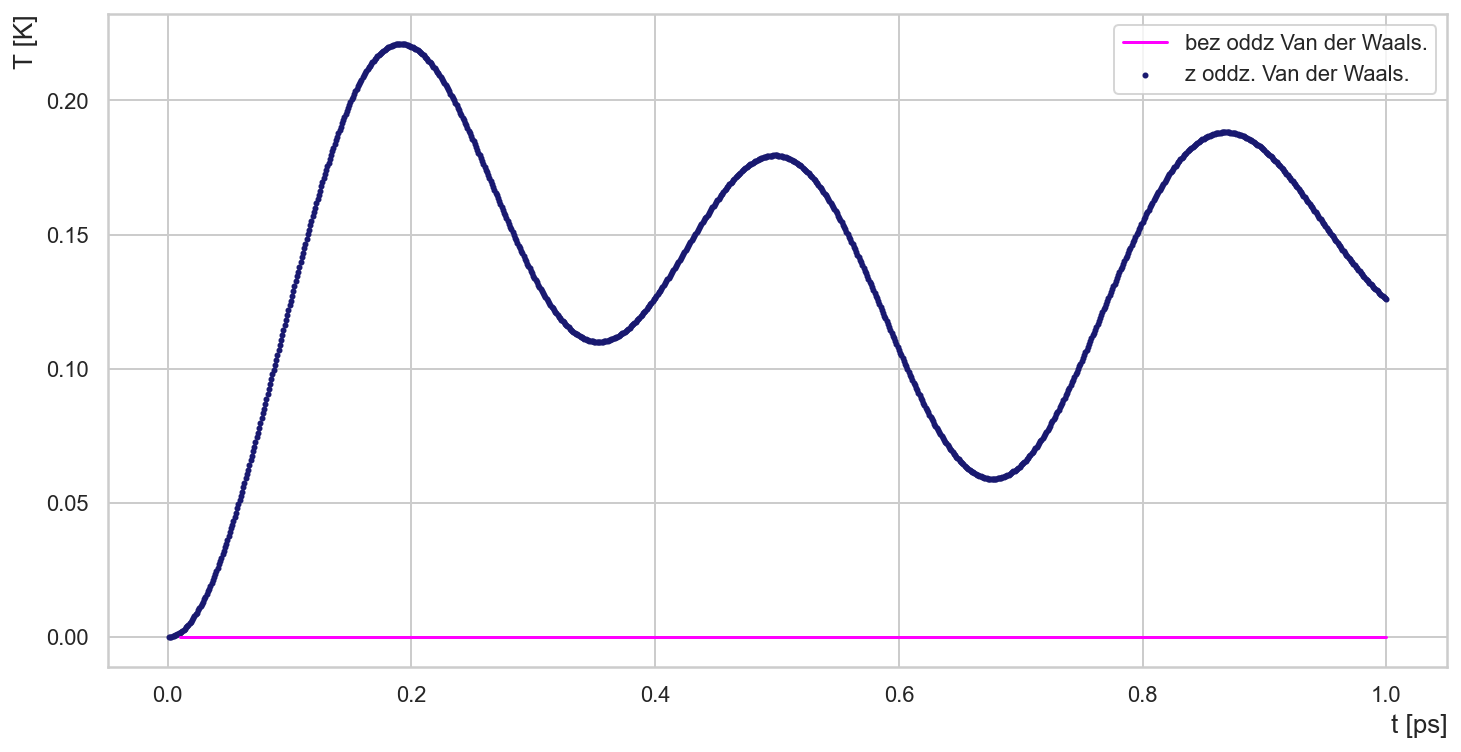

In [33]:
data_a = np.loadtxt("./output/out_a.txt", skiprows=1)
df_a = pd.DataFrame(data_a, columns = ['t','H','V', 'T', 'P'])

data_a2 = np.loadtxt("./output/out_bezFi.txt", skiprows=1)
df_a2 = pd.DataFrame(data_a2, columns = ['t','H','V', 'T', 'P'])

fig = plt.figure(figsize = (12, 6))
plt.scatter(df_a['t'], df_a['T'], color = 'midnightblue', s = 4, label = 'z oddz. Van der Waals.')
plt.plot(df_a2['t'], df_a2['T'], color = 'magenta', label = 'bez oddz Van der Waals.')
plt.xlabel("t [ps]", fontsize=13, loc='right')
_ = plt.ylabel("T [K]", fontsize=13, loc='top')
plt.legend()
plt.savefig('./figs/Ta.pdf')

<center>Fig. 5. Zalezność chwilowej wartości temperatury od czasu dla wybranego a = 0.373 nm (pozostałe parametry jw.).</center>

<a name='33'></a>
## 3.3 Topnienie kryształu

Dla n = 5, a = 0.373, L = 2.3 wykonano symulacje przy różnych temperaturach początkowych T0. 

Na podstawie obserwacji przygotowanej animacji temperaturę topnienia kryształu oszacowano na ok. 85K.

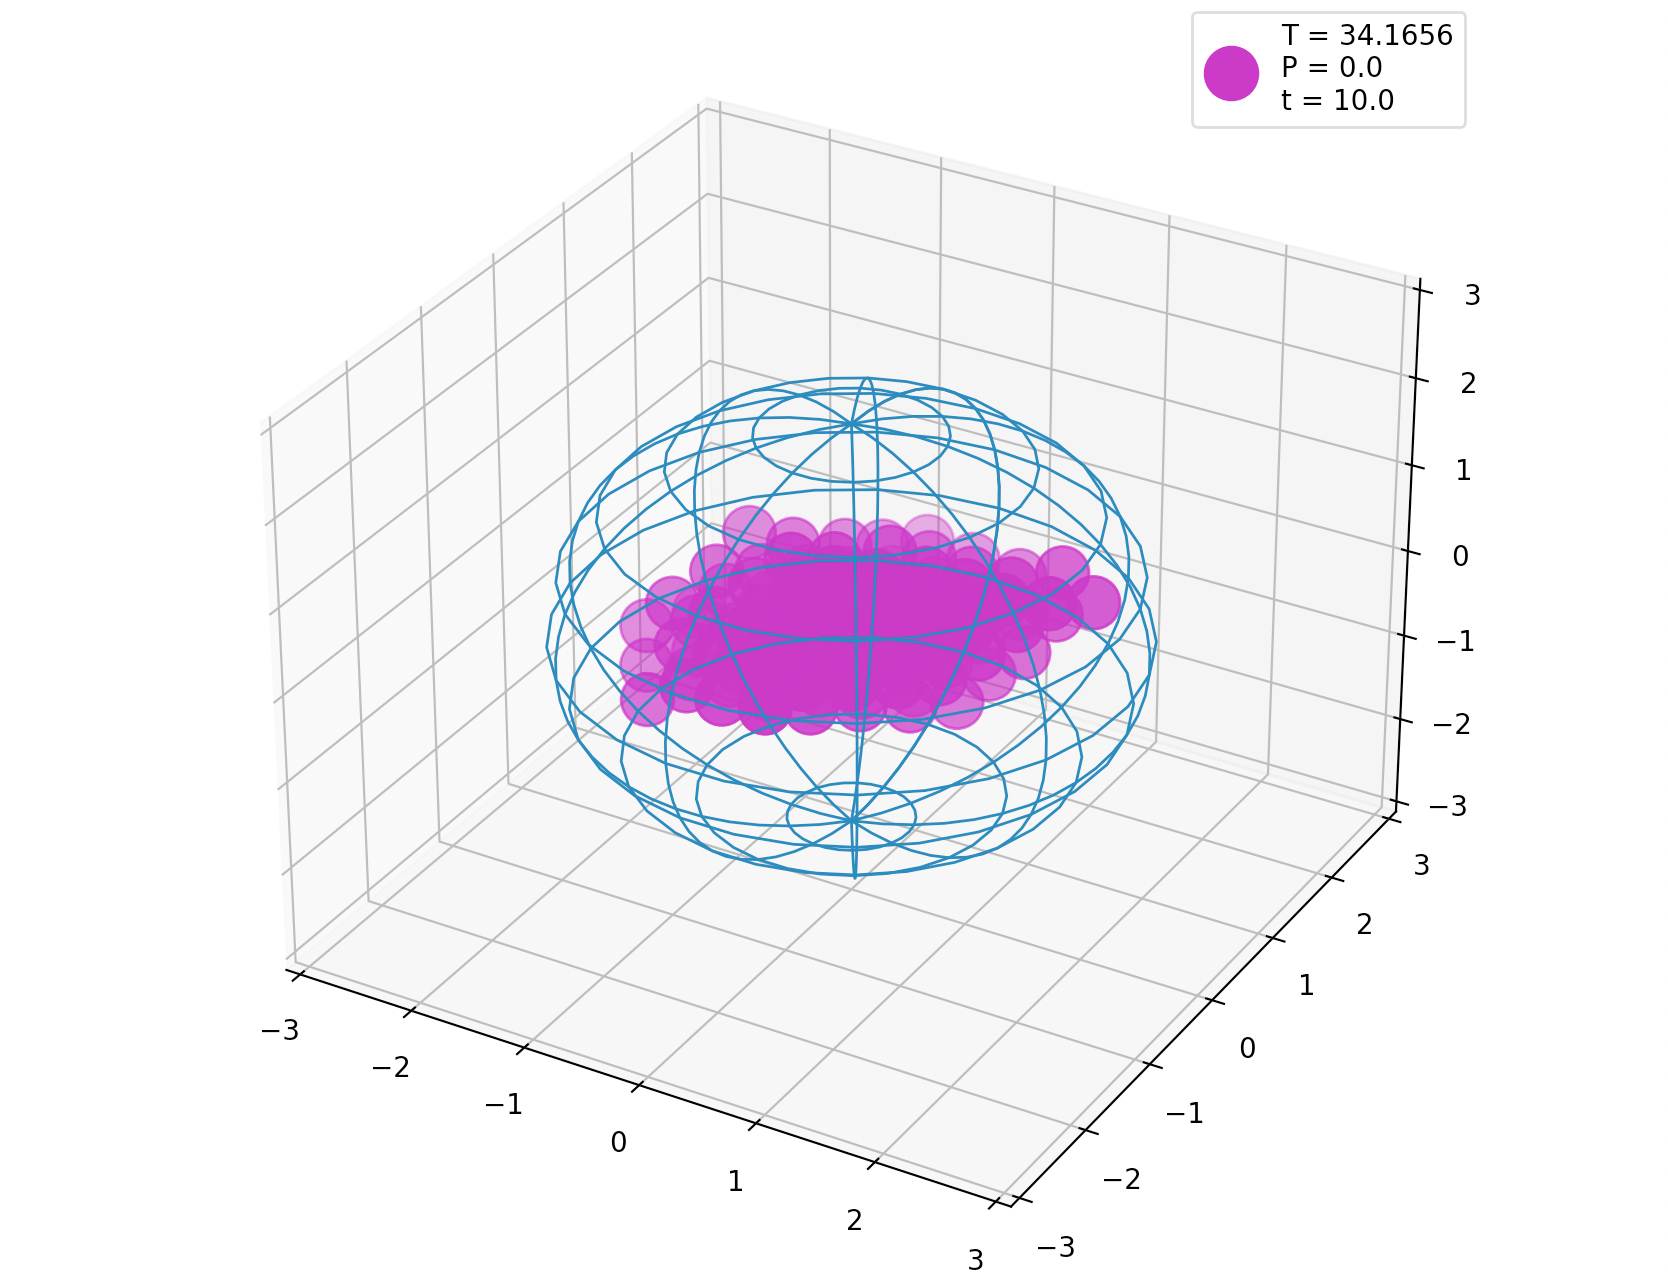

In [17]:
Image(filename = "./output/temp_topnienia/T0_85.png", width = 600, height = 300)

<center>Fig. 6. Stan po 10ps symulacji dla T0 = 85K </center>

<a name='34'></a>
## 3.4 gaz

Dla T0 = 500K, 1000K, 1500K, 2000K zbadano zachowanie temperatury i ciśnienia chwilowego. Dla każdej wartości temperatury początkowej T0 wyznacozno czas So potrzebny na stopienie kryształu i termalizację gazu. 

Zbadano również zalezność średnich wartości temperatury i ciśnienia i porównano je z gazem doskonałym. 

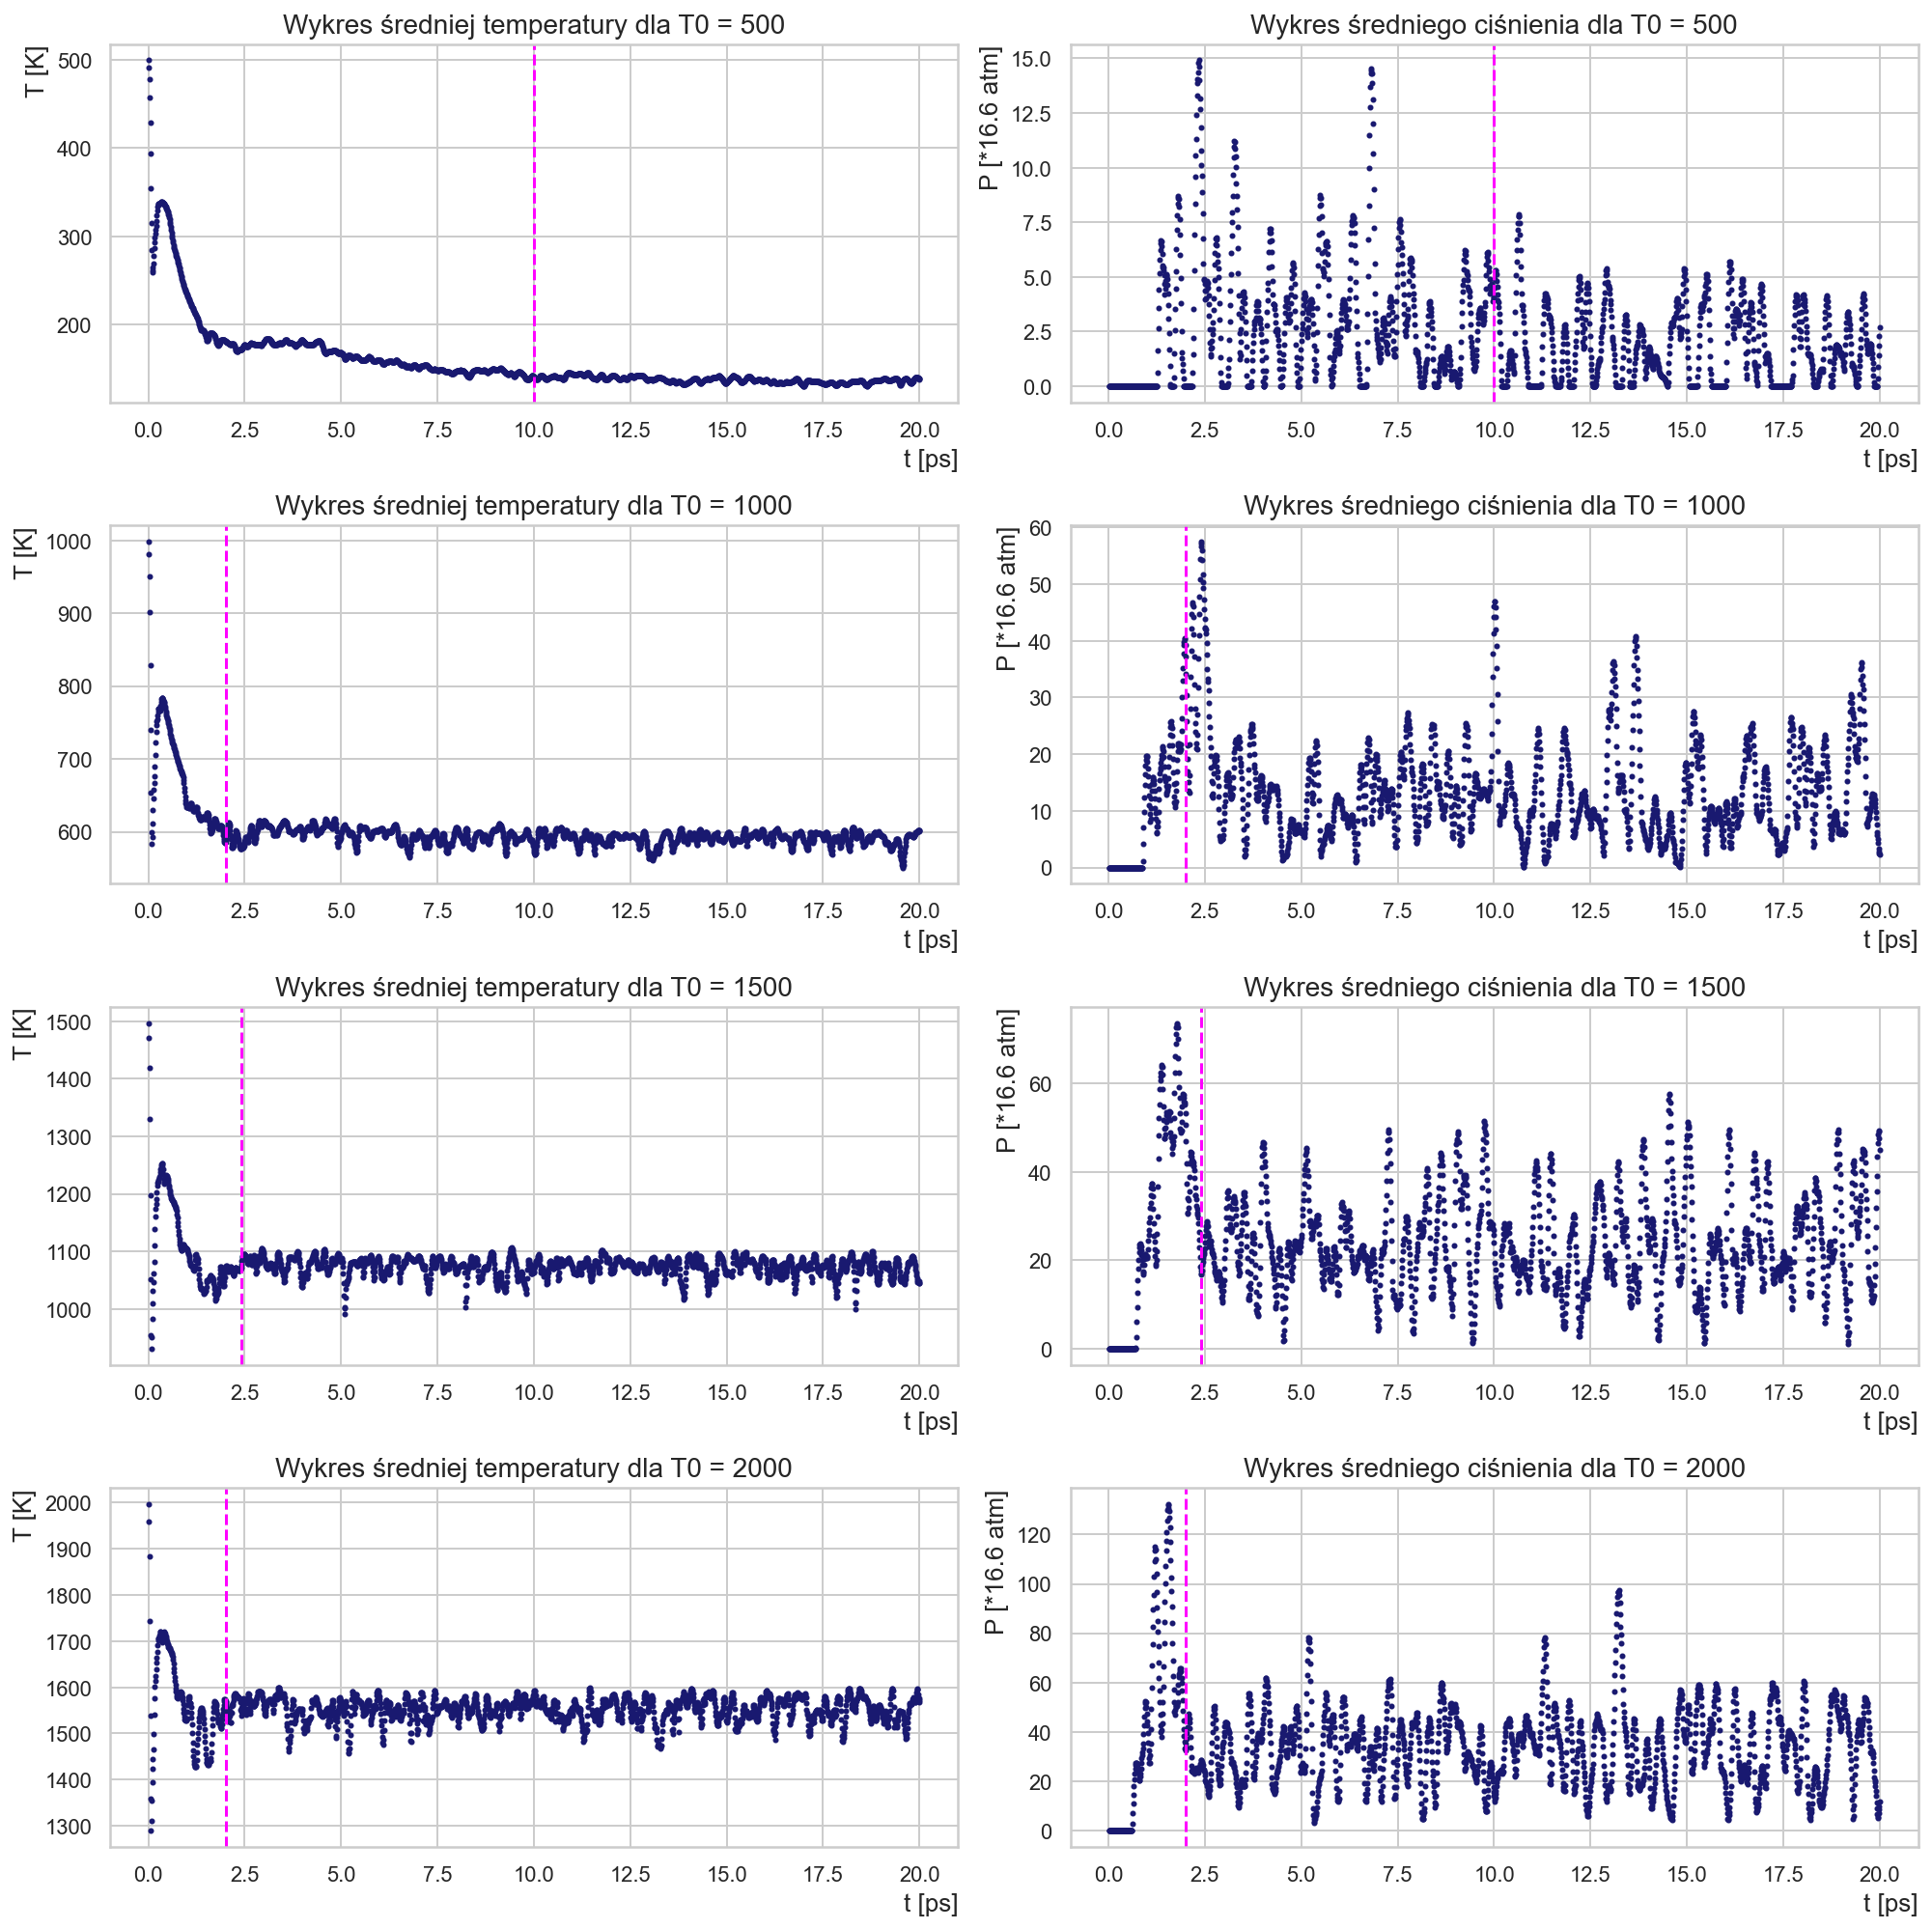

In [25]:
data_T500 = np.loadtxt("./output/out_T500.txt", skiprows=1)
df_T500 = pd.DataFrame(data_T500, columns = ['t','H','V', 'T', 'P'])

data_T1000 = np.loadtxt("./output/out_T1000.txt", skiprows=1)
df_T1000 = pd.DataFrame(data_T1000, columns = ['t','H','V', 'T', 'P'])

data_T1500 = np.loadtxt("./output/out_T1500.txt", skiprows=1)
df_T1500 = pd.DataFrame(data_T1500, columns = ['t','H','V', 'T', 'P'])

data_T2000 = np.loadtxt("./output/out_T2000.txt", skiprows=1)
df_T2000 = pd.DataFrame(data_T2000, columns = ['t','H','V', 'T', 'P'])



#T0 = 500K
fig = plt.figure(figsize = (14, 14))
plt.subplot(4, 2, 1)
plt.scatter(df_T500['t'], df_T500['T'], color = 'midnightblue', s = 4)
plt.axvline(x=10, color = 'magenta', ls = '--')
plt.title("Wykres średniej temperatury dla T0 = 500", fontsize = 14)
plt.xlabel("t [ps]", fontsize=13, loc='right')
_ = plt.ylabel("T [K]", fontsize=13, loc='top')
plt.subplot(4, 2, 2)
plt.scatter(df_T500['t'], df_T500['P'], color = 'midnightblue', s = 4)
plt.axvline(x=10, color = 'magenta', ls = '--')
plt.title("Wykres średniego ciśnienia dla T0 = 500", fontsize = 14)
plt.xlabel("t [ps]", fontsize=13, loc='right')
_ = plt.ylabel("P [*16.6 atm]", fontsize=13, loc='top')


#T0 = 1000K
plt.subplot(4, 2, 3)
plt.scatter(df_T1000['t'], df_T1000['T'], color = 'midnightblue', s = 4)
plt.axvline(x=2, color = 'magenta', ls = '--')
plt.title("Wykres średniej temperatury dla T0 = 1000", fontsize = 14)
plt.xlabel("t [ps]", fontsize=13, loc='right')
_ = plt.ylabel("T [K]", fontsize=13, loc='top')
plt.subplot(4, 2, 4)
plt.scatter(df_T1000['t'], df_T1000['P'], color = 'midnightblue', s = 4)
plt.axvline(x=2, color = 'magenta', ls = '--')
plt.title("Wykres średniego ciśnienia dla T0 = 1000", fontsize = 14)
plt.xlabel("t [ps]", fontsize=13, loc='right')
_ = plt.ylabel("P [*16.6 atm]", fontsize=13, loc='top')


#T0 = 1500K
plt.subplot(4, 2, 5)
plt.scatter(df_T1500['t'], df_T1500['T'], color = 'midnightblue', s = 4)
plt.axvline(x=2.4, color = 'magenta', ls = '--')
plt.title("Wykres średniej temperatury dla T0 = 1500", fontsize = 14)
plt.xlabel("t [ps]", fontsize=13, loc='right')
_ = plt.ylabel("T [K]", fontsize=13, loc='top')
plt.subplot(4, 2, 6)
plt.scatter(df_T1500['t'], df_T1500['P'], color = 'midnightblue', s = 4)
plt.axvline(x=2.4, color = 'magenta', ls = '--')
plt.title("Wykres średniego ciśnienia dla T0 = 1500", fontsize = 14)
plt.xlabel("t [ps]", fontsize=13, loc='right')
_ = plt.ylabel("P [*16.6 atm]", fontsize=13, loc='top')


#T0 = 2000K
plt.subplot(4, 2, 7)
plt.scatter(df_T2000['t'], df_T2000['T'], color = 'midnightblue', s = 4)
plt.axvline(x=2, color = 'magenta', ls = '--')
plt.title("Wykres średniej temperatury dla T0 = 2000", fontsize = 14)
plt.xlabel("t [ps]", fontsize=13, loc='right')
_ = plt.ylabel("T [K]", fontsize=13, loc='top')
plt.subplot(4, 2, 8)
plt.scatter(df_T2000['t'], df_T2000['P'], color = 'midnightblue', s = 4)
plt.axvline(x=2, color = 'magenta', ls = '--')
plt.title("Wykres średniego ciśnienia dla T0 = 2000", fontsize = 14)
plt.xlabel("t [ps]", fontsize=13, loc='right')
_ = plt.ylabel("P [*16.6 atm]", fontsize=13, loc='top')



fig.tight_layout()
plt.savefig('./figs/termalizacja.pdf')

<center>Fig. 7. Wykresy chwilowej temperatury i ciśnienia dla różnych T0, przy n = 5, a = 0.373, L = 2.3. Różową linią oznaczono czas termalizacji. </center>

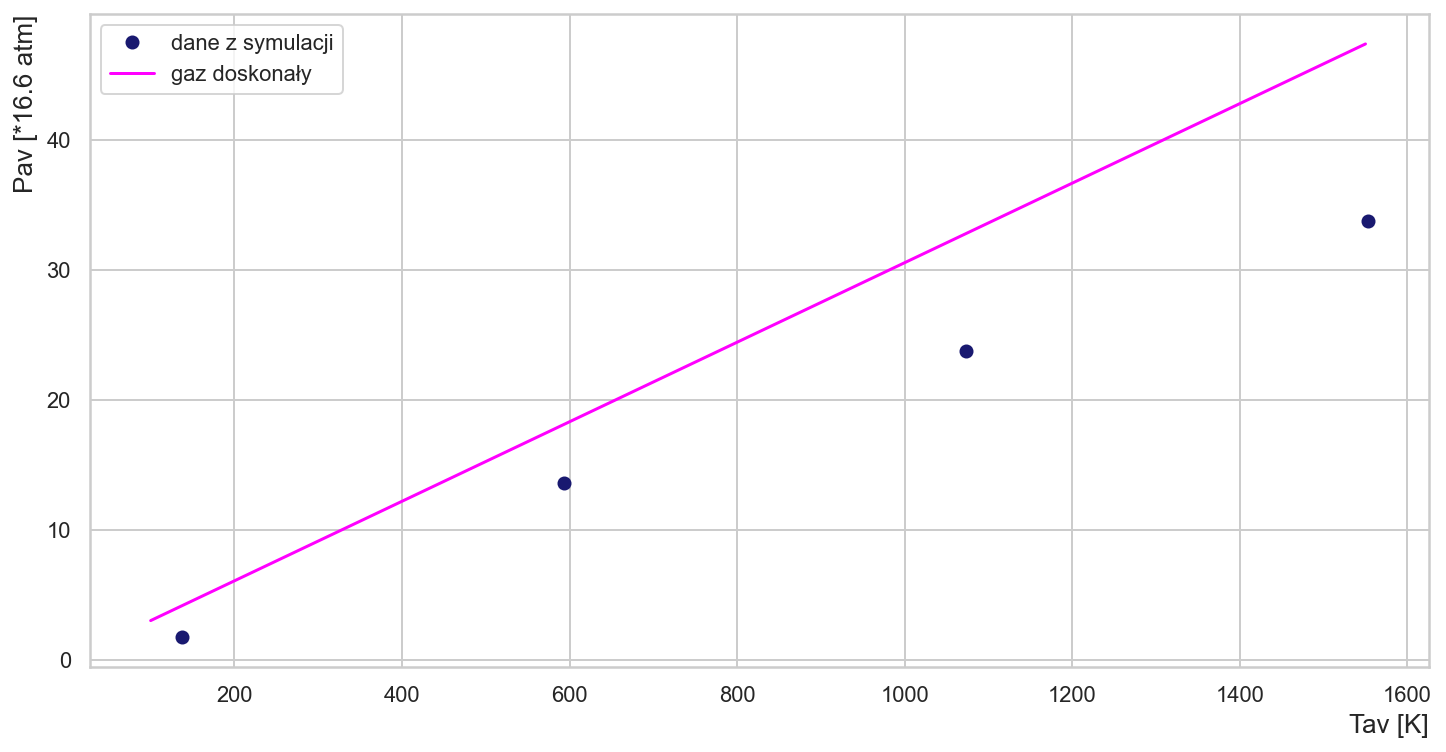

In [26]:
Pav = [1.8002480080785863, 13.630153957724646, 23.77046214862641, 33.760240079599896]
Tav = [137.77692321318693, 593.4311462062864, 1073.687287965512, 1553.0862864918317]

Tt = np.arange(100, 1600, 50)
Pp = 0.030572445*Tt
fig = plt.figure(figsize = (12, 6))
plt.plot(Tav, Pav, 'o', color = 'midnightblue', label = 'dane z symulacji')
plt.plot(Tt, Pp, color = 'magenta', label = 'gaz doskonały')
plt.xlabel("Tav [K]", fontsize=13, loc='right')
plt.ylabel("Pav [*16.6 atm]", fontsize=13, loc='top')
_ = plt.legend()
plt.savefig('./figs/PodT.pdf')

<center>Fig. 8. Zależność średniego ciśnienia od średniej temperatury.</center>

Zależność ciśnienia od temperatury ma charakter liniowy, jednak ponieważ badany jest gaz rzeczywisty punkty na wykresie mają inne nachylenie niż krzywa dla gazu doskonałego.

<a name='4'></a>
# 4. Kod symulacji
[Repozytorium z kodem](https://github.com/pauczy/KMS1)